# Generating Weekday and Weekend profiles

In [155]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import os
from importlib import reload
logging.getLogger('matplotlib.font_manager').disabled = True
from importlib import reload

from kmodes.kprototypes import KPrototypes

import pandas as pd
import cluster_statistics_kProt

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return



In [156]:
pattern = f"{"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized"}/*CH*.csv"
#pattern = f"{"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekend_normalized"}/*CH*.csv"
file_paths = glob.glob(pattern)

In [157]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:15])  # Preview first 10 extracted CH... names

train_data = data_3d

n_samples = data_3d.shape[0]



Shape of the 3D array: (1481, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197', 'CH1018601234500000000000000019524', 'CH1018601234500000000000000080658', 'CH1018601234500000000000000018881', 'CH1018601234500000000000000108521', 'CH1018601234500000000000000113022']


In [158]:
key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"

df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

cols_to_extract = [10, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 127, 129, 155, 131, 128, 156, 157, 158, 159, 160]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['House_id', 'Building Type', 'Heating', 'Water Heating', 
                        'Solar Panels', 'Electric Vehicle', 'Heat Pump', 'Individual Electric Boiler', 
                        'Individual Washing Machine', 'Home Battery','Number of Residents',
                        'Number of Days at Home','Age','Education', 'Employment', 'Tenant Type',
                        'Income','DR scenario', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances']

#extracted_df['DR scenario'] = extracted_df['DR scenario'].astype(str)

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["House_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house_id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate House_id entries.")
else:
    print("No duplicates found in House_id column.")

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['House_id'].map(mapping)

print(filename_list[:15])

Total rows: 1500
Unique house_id count: 1500
No duplicates found in House_id column.
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197', 'CH1018601234500000000000000019524', 'CH1018601234500000000000000080658', 'CH1018601234500000000000000018881', 'CH1018601234500000000000000108521', 'CH1018601234500000000000000113022']


In [159]:
#read the file according to the filenames extracted before

#result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Survey/hourly_avg_clustering_category.csv')

result_df = extracted_df

result_df = pl.from_pandas(result_df)

extracted_df = pl.from_pandas(extracted_df)

print(type(result_df))

order_dict = {house_id: i for i, house_id in enumerate(filename_list)}

ordered_rows = [result_df.filter(pl.col("CH_id") == filename) for filename in filename_list]
ordered_result_df = pl.concat(ordered_rows)

print(ordered_result_df['CH_id'].to_list()[:10])

print(len(ordered_result_df))



<class 'polars.dataframe.frame.DataFrame'>
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']
1481


In [160]:
from pandas.api.types import CategoricalDtype

# Load categorical column as pandas category
category_df = ordered_result_df.select(['Building Type', 'Individual Electric Boiler', 'Individual Washing Machine']).to_pandas().astype('category')

building_type_categories = ['No Information', 'Flat', 'House']
electric_boiler_categories = ['No Information', 'No', 'Yes']
washing_machine_categories = ['No Information', 'No', 'Yes']
number_of_days_at_home_categories = ['No Information', '0', '1', '2', '3', '4', '5', '6', '7']

#category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(str)

#age_cat_type = CategoricalDtype(categories=age_categories, ordered=False)
#days_cat_type = CategoricalDtype(categories=days_at_home_categories, ordered=False)
building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=False)
electric_boiler_cat_type = CategoricalDtype(categories=electric_boiler_categories, ordered=False)
washing_machine_cat_type = CategoricalDtype(categories=washing_machine_categories, ordered=False)
number_of_days_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=False)



category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
category_df['Individual Electric Boiler'] = category_df['Individual Electric Boiler'].astype(electric_boiler_cat_type)
category_df['Individual Washing Machine'] = category_df['Individual Washing Machine'].astype(washing_machine_cat_type)
#category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(number_of_days_cat_type)

rows_to_keep_indices = []

for i, row in category_df.iterrows():
    # Check if 'No Information' NOT in any value of that row
    if "No Information" not in row.values:
        # Check if 'Flat' NOT in any value of that row
        if "House" not in row.values:
            rows_to_keep_indices.append(i)

#print(category_df['Number of Days at Home'].unique())

category_df = category_df.drop(columns=['Building Type'])



# Fill NaN with "No information"
#category_df['age'] = category_df['age'].fillna('No information')

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

# Convert to NumPy array
category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

#rows_to_keep_indices = []

#for i, row in enumerate(combined_data):
#    if "No Information" not in row:
#        if "Flat" not in row:
#            rows_to_keep_indices.append(i)

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]


print(len(combined_data))
print(combined_data)

801
[[0.18794544 0.18459822 0.18250336 ... 0.19177084 1.         2.        ]
 [0.38126084 0.37192696 0.38233194 ... 0.38008773 1.         2.        ]
 [0.16163106 0.14720701 0.14340872 ... 0.16638677 1.         2.        ]
 ...
 [0.25417859 0.24435412 0.2363706  ... 0.27129395 1.         1.        ]
 [0.17920543 0.17870329 0.1756166  ... 0.17957466 1.         1.        ]
 [0.21970255 0.19906346 0.15843836 ... 0.23247229 1.         2.        ]]


In [161]:
# 5. Specify the categorical feature column indices (the last 3 columns)

print(list(range(combined_data.shape[1] - 2, combined_data.shape[1])))
categorical_indices = list(range(combined_data.shape[1] - 2, combined_data.shape[1]))

numerical_indices = list(range(0, combined_data.shape[1]-2))



[96, 97]


In [162]:
%%skip

import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

cluster_range = range(1, 9)  # Try 2-10 clusters
gamma_range = np.linspace(0, 3.5, 8)

# Store costs for each gamma value; key: gamma, value: list of costs per cluster count
costs_dict = {}

for gamma in gamma_range:
    costs_for_gamma = []
    for n_clusters in cluster_range:
        kproto = KPrototypes(
            n_clusters=n_clusters,
            init='Cao',
            verbose=0,
            max_iter=500,
            gamma=gamma,  # use current gamma value
            random_state=42,
            n_init=10
        )
        kproto.fit_predict(combined_data, categorical=categorical_indices)
        costs_for_gamma.append(kproto.cost_)
        #print(f"Clusters: {n_clusters}, Gamma: {gamma:.2f}, Cost: {kproto.cost_}")
    costs_dict[gamma] = costs_for_gamma

# Plot costs per cluster for each gamma line
plt.figure(figsize=(10, 6))
for gamma, costs_for_gamma in costs_dict.items():
    plt.plot(cluster_range, costs_for_gamma, marker='o', label=f'Gamma={gamma:.2f}')

plt.xlabel('Number of clusters')
plt.ylabel('K-Prototypes cost [-]')
plt.ylim(0, max(max(c) for c in costs_dict.values()) * 1.1)
plt.title('K-Prototypes Cost per Cluster Number for Different Gamma Values - Flats')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend(title='Weighting')
plt.tight_layout()
plt.savefig('/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/kPrototypes_cost_flats.png')
plt.show()

In [163]:
# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=4, 
    init='Cao', 
    verbose=0, 
    max_iter=500, 
    gamma=3,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

In [164]:
#print(clusters)

#remap = {3: 4, 4: 1, 1: 2, 2: 3} #hourlyAveraged

#remap = {4: 1, 1: 2, 2: 3, 3: 4} #hourlyAvergaedSummer

#remap = {4: 1, 1: 2, 2: 3, 3: 4} #hourlyAvergaedWinter

#remap = {3: 4, 4: 1, 1: 2, 2: 3} #hourlyAvergaedWeekday

#remap = {4: 1, 1: 2, 2: 3, 3: 4} #hourlyAvergaedWeekday

#clusters = np.vectorize(remap.get)(clusters)

#print(clusters)

In [165]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters
}).sort("cluster")

result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering_kProt_flat.csv")

Cluster 1 size: 331
Cluster 2 size: 60
Cluster 3 size: 332
Cluster 4 size: 78


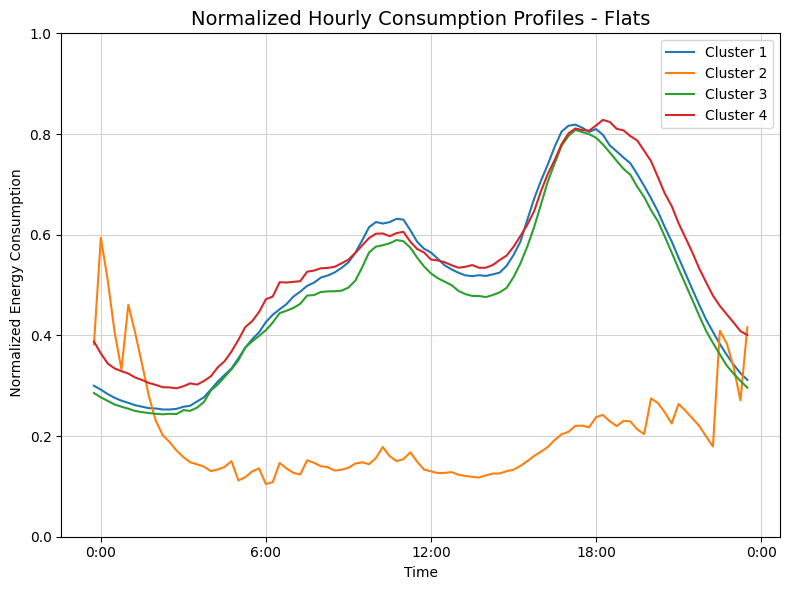

In [166]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

plt.figure(figsize=(8, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title("Normalized Hourly Consumption Profiles - Flats", fontsize=14)
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
#plt.xticks(range(1,108,12),labels=labels)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
#plt.legend()
#plt.margins(0)
plt.grid(True, color = 'lightgray')
plt.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/HourlyAveraged_KProt_flat.png",
    bbox_inches='tight'
    )
plt.show()



In [167]:
print(combined_data[:, 0:96])

numerical_data_sc = combined_data[:, 0:96]

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


score = silhouette_score(numerical_data_sc, clusters, metric='euclidean')
print("Silhouette score (time series only):", score)

db_index = davies_bouldin_score(numerical_data_sc, clusters)
print("Davies-Bouldin Index (time series only):", db_index)

[[0.18794544 0.18459822 0.18250336 ... 0.20397568 0.19539131 0.19177084]
 [0.38126084 0.37192696 0.38233194 ... 0.42578802 0.37172294 0.38008773]
 [0.16163106 0.14720701 0.14340872 ... 0.17569413 0.16814465 0.16638677]
 ...
 [0.25417859 0.24435412 0.2363706  ... 0.31702605 0.28771668 0.27129395]
 [0.17920543 0.17870329 0.1756166  ... 0.19911387 0.1861025  0.17957466]
 [0.21970255 0.19906346 0.15843836 ... 0.29894257 0.2594013  0.23247229]]
Silhouette score (time series only): 0.009344706233545469
Davies-Bouldin Index (time series only): 7.4961979227067435


Clusters: 2, Gamma: 0.0, Silhouette Score: 0.436
Clusters: 2, Gamma: 0.5, Silhouette Score: 0.423
Clusters: 2, Gamma: 1.0, Silhouette Score: 0.371
Clusters: 2, Gamma: 1.5, Silhouette Score: 0.334
Clusters: 2, Gamma: 2.0, Silhouette Score: 0.312
Clusters: 2, Gamma: 2.5, Silhouette Score: 0.295
Clusters: 2, Gamma: 3.0, Silhouette Score: 0.286
Clusters: 2, Gamma: 3.5, Silhouette Score: 0.307
Clusters: 2, Gamma: 4.0, Silhouette Score: 0.349
Clusters: 3, Gamma: 0.0, Silhouette Score: 0.393
Clusters: 3, Gamma: 0.5, Silhouette Score: 0.367
Clusters: 3, Gamma: 1.0, Silhouette Score: 0.335
Clusters: 3, Gamma: 1.5, Silhouette Score: 0.312
Clusters: 3, Gamma: 2.0, Silhouette Score: 0.292
Clusters: 3, Gamma: 2.5, Silhouette Score: 0.329
Clusters: 3, Gamma: 3.0, Silhouette Score: 0.359
Clusters: 3, Gamma: 3.5, Silhouette Score: 0.386
Clusters: 3, Gamma: 4.0, Silhouette Score: 0.408
Clusters: 4, Gamma: 0.0, Silhouette Score: 0.310
Clusters: 4, Gamma: 0.5, Silhouette Score: 0.296
Clusters: 4, Gamma: 

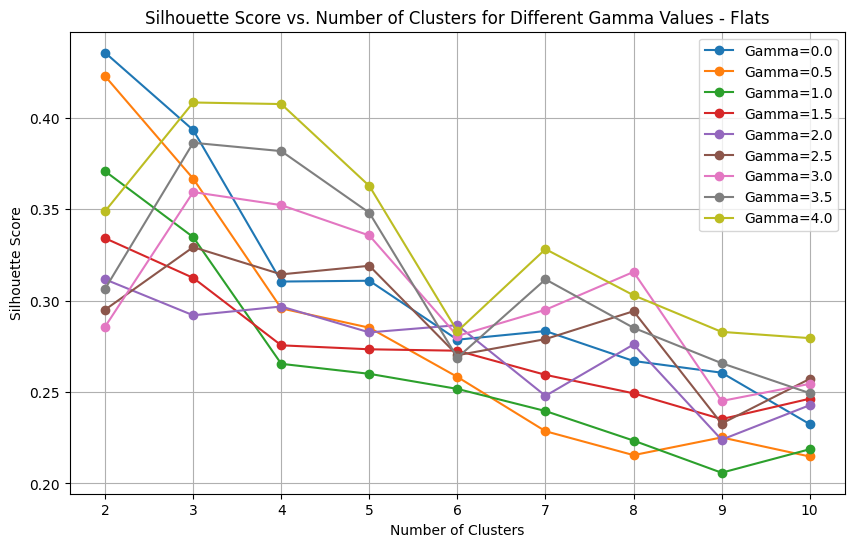

In [168]:
#%%skip

import numpy as np
import matplotlib.pyplot as plt
from kmodes import kprototypes
from sklearn.metrics import silhouette_score

categorical = categorical_indices  # e.g., [0, 2, 4]
gamma_values = np.linspace(0, 4, 9)     # gamma = 0 to 9
cluster_values = range(2, 11)        # number of clusters from 2 to 7
silhouette_scores = np.zeros((len(cluster_values), len(gamma_values)))

def mixed_distance(a, b, categorical, gamma):
    num_idx = [i for i in range(len(a)) if i not in categorical]
    num_dist = np.sum((a[num_idx] - b[num_idx]) ** 2)
    cat_dist = np.sum(a[categorical] != b[categorical])
    return num_dist + gamma * cat_dist

def create_distance_matrix(X, categorical, gamma):
    n = X.shape[0]
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = mixed_distance(X[i], X[j], categorical, gamma)
            dm[i, j] = dm[j, i] = d
    return dm

for i, n_clusters in enumerate(cluster_values):
    for j, gamma in enumerate(gamma_values):
        distance_matrix = create_distance_matrix(combined_data, categorical, gamma)
        model = kprototypes.KPrototypes(n_clusters=n_clusters, gamma=gamma,random_state=42,n_init=10)
        labels = model.fit_predict(combined_data, categorical=categorical)
        score = silhouette_score(distance_matrix, labels, metric="precomputed")
        silhouette_scores[i, j] = score
        print(f"Clusters: {n_clusters}, Gamma: {gamma}, Silhouette Score: {score:.3f}")
# Plot results: multiple curves of silhouette score for each cluster number
plt.figure(figsize=(10, 6))
for j, gamma in enumerate(gamma_values):
    plt.plot(cluster_values, silhouette_scores[:, j], marker='o', label=f'Gamma={gamma}')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for Different Gamma Values - Flats')
plt.legend()
plt.grid(True)
plt.savefig('/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/kPrototypes_SC_flats.png')
plt.show()



In [169]:
#%%skip

from kmodes import kprototypes
from sklearn.metrics import silhouette_score
import numpy as np

def mixed_distance(a, b, categorical, gamma):
    num_idx = [i for i in range(len(a)) if i not in categorical]
    num_dist = np.sum((a[num_idx] - b[num_idx]) ** 2)
    cat_dist = np.sum(a[categorical] != b[categorical])
    return num_dist + gamma * cat_dist

def create_distance_matrix(X, categorical, gamma):
    n = X.shape[0]
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = mixed_distance(X[i], X[j], categorical, gamma)
            dm[i, j] = dm[j, i] = d
    return dm

# Suppose X is your data (after preprocessing, as used with K-Prototypes)
categorical = categorical_indices  # replace with your categorical column indices
gamma = 3  # use the value from your model

distance_matrix = create_distance_matrix(combined_data, categorical, gamma)

# Fit K-Prototypes and get labels:
model = kprototypes.KPrototypes(n_clusters=5, gamma=gamma)
labels = model.fit_predict(combined_data, categorical=categorical)

# Compute silhouette score:
from sklearn.metrics import silhouette_score
score = silhouette_score(distance_matrix, labels, metric="precomputed")
print("Silhouette score:", score)


Silhouette score: 0.3199899561728914


(801, 96, 1)


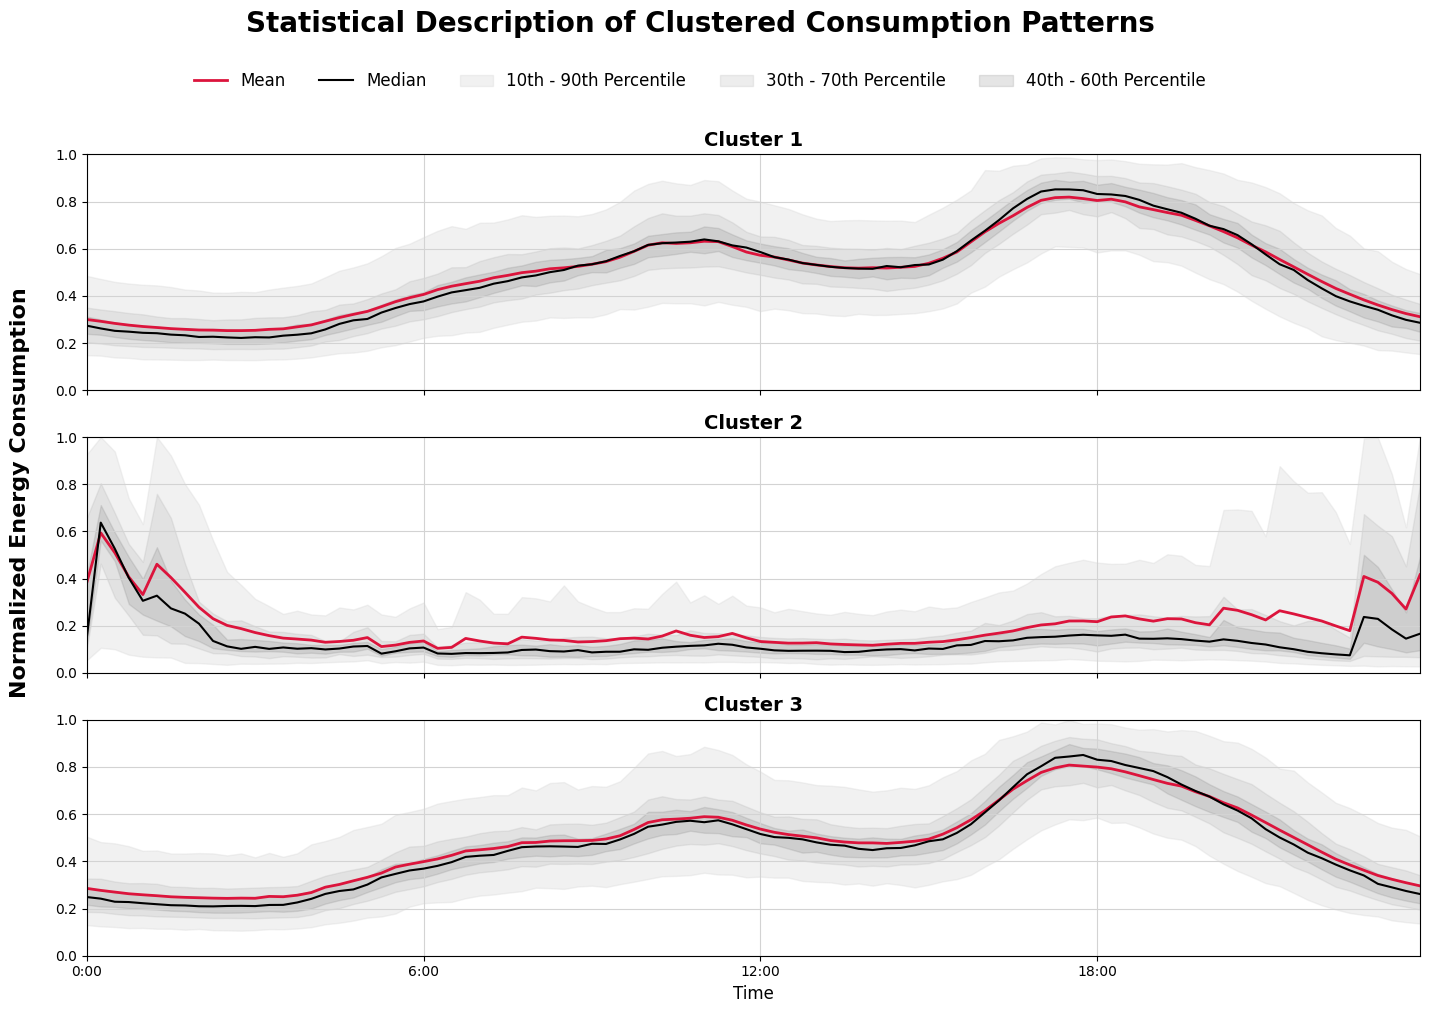

In [170]:
number_of_clusters = 3

reload(cluster_statistics_kProt)

from cluster_statistics_kProt import plot_cluster_percentiles

data_3d_kProt = np.expand_dims(time_series_numeric, axis=-1)

print(data_3d_kProt.shape)

#print(data_3d_kProt)

for i in range(number_of_clusters):

    i = i+1
    # Select samples for the current cluster
    cluster_data = time_series_numeric[clusters == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue  # Skip this cluster

plot_cluster_percentiles(data_3d_kProt,clusters,number_of_clusters, building_type= 'Flat')

In [171]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering_kProt_flat.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption",
        "average_hourly_consumption",
        "bruttolastgang_kwh_max"
    ]),
    on="ch_id_clean",
    how="left"
)
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption" ,
    "average_hourly_consumption",
    "bruttolastgang_kwh_max"
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2),
    pl.mean("average_hourly_consumption").alias("avg_hourly_consumption [kWh]").round(2),
    pl.mean("bruttolastgang_kwh_max").alias("avg_max_consumption [kWh]").round(2)
    
]).sort("cluster")

cluster_summary = cluster_summary.with_columns([
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households")/1000).alias("combined_max_consumption [MWh]").round(2)
])

print(cluster_summary)

shape: (4, 7)
┌─────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ cluster ┆ num_househol ┆ avg_total_co ┆ avg_daily_co ┆ avg_hourly_c ┆ avg_max_cons ┆ combined_ma │
│ ---     ┆ ds           ┆ nsumption    ┆ nsumption    ┆ onsumption   ┆ umption      ┆ x_consumpti │
│ i64     ┆ ---          ┆ [kWh]        ┆ [kWh]        ┆ [kWh]        ┆ [kWh]        ┆ on [MWh]    │
│         ┆ u32          ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│         ┆              ┆ f64          ┆ f64          ┆ f64          ┆ f64          ┆ f64         │
╞═════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ 1       ┆ 331          ┆ 3378.74      ┆ 5.63         ┆ 0.23         ┆ 1.21         ┆ 1118.36     │
│ 2       ┆ 60           ┆ 4236.31      ┆ 7.45         ┆ 0.31         ┆ 1.27         ┆ 254.18      │
│ 3       ┆ 332          ┆ 2187.39      ┆ 3.83         ┆ 0.16         ┆ 1.11 

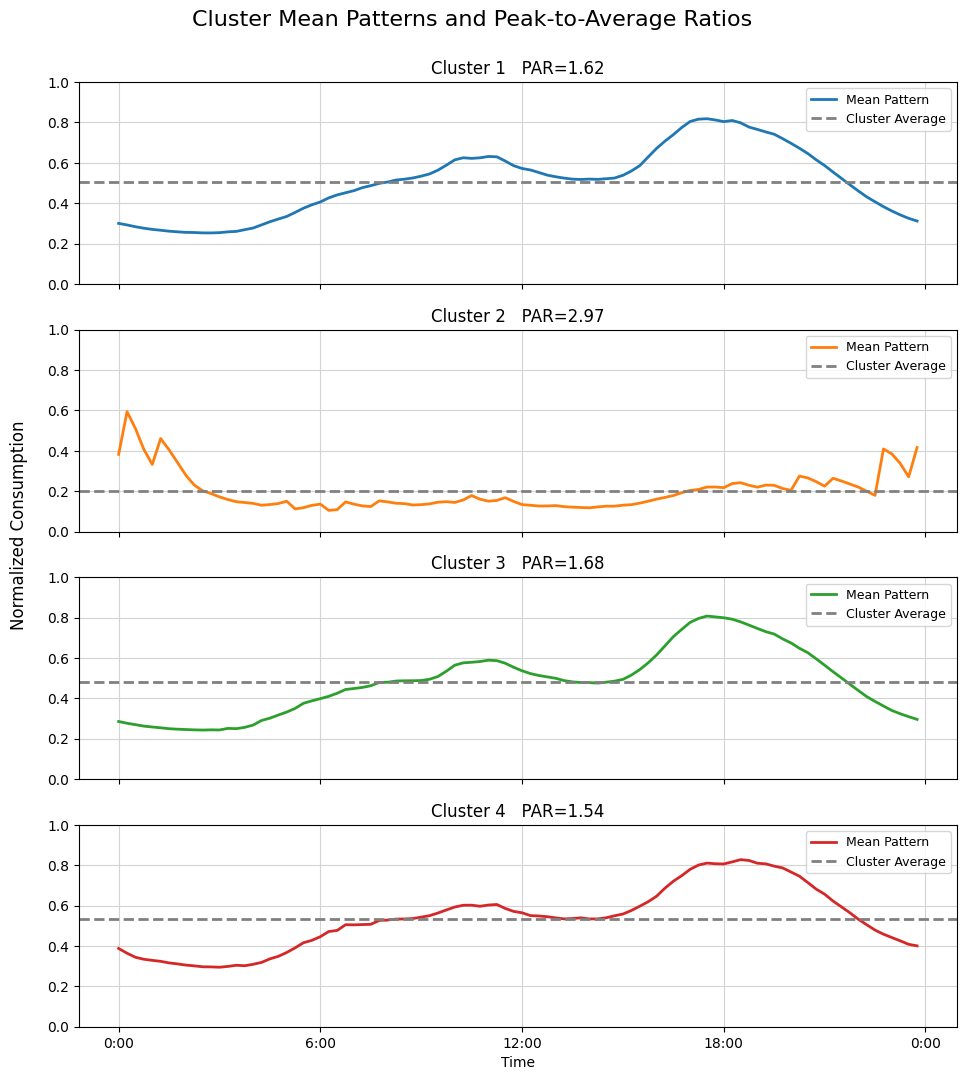

In [172]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])  # Keine X-Ticks für die oberen Subplots
    # ACHTUNG: Kein ax.set_ylabel() hier!

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/PAR_KProt_flat.png",
    bbox_inches='tight'
)
plt.show()

In [173]:
#'electric water heating', 'building type', 'solar panels', 'electric vehicle', 'days at home'

# Create DataFrame with cluster labels and decoded categorical feature
df = pd.DataFrame({
    'cluster': clusters,
    'Individual Electric Boiler': [electric_boiler_categories[int(code)] for code in combined_data[:, -2]],
    'Individual Washing Machine': [washing_machine_categories[int(code)] for code in combined_data[:, -1]],
    #'Number of Days at Home': [number_of_days_at_home_categories[int(code)] for code in combined_data[:, -1]]
})
print(df.head())



   cluster Individual Electric Boiler Individual Washing Machine
0        1                         No                        Yes
1        1                         No                        Yes
2        1                         No                        Yes
3        3                         No                         No
4        3                         No                         No


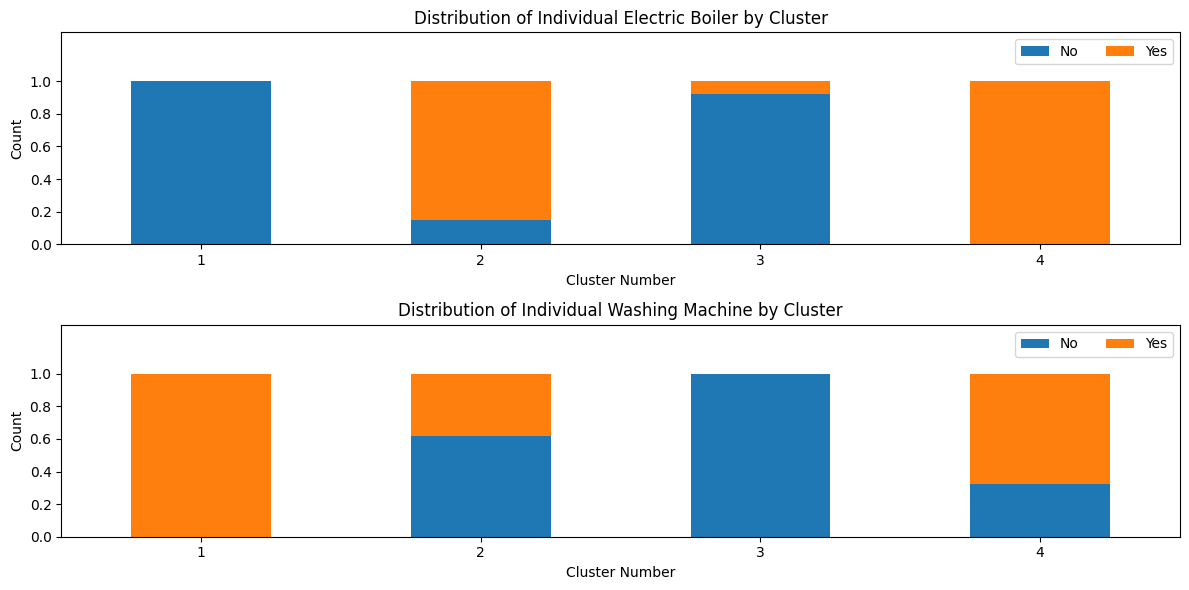

In [174]:
# Number of categorical features to plot
category_features = ['Individual Electric Boiler', 'Individual Washing Machine']
n_features = len(category_features)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes only up to 1.15 (bars max out at 1, extra space for DR titles)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Rotate x-ticks for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=10,
    fontsize='medium'
)
plt.savefig(
"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Survey/categories_tech_flat.png",
bbox_inches='tight'
)
plt.tight_layout()
plt.show()